### download lung-cancer-dataset

url::https://github.com/Harry24k/Pytorch-Basic/blob/master/Week5/20.%20Transfer%20Learning%20with%20Inception%20v3.ipynb

In [40]:
import os
# import pandas as pd
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Definir las transformaciones
data_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception_v3 requiere imágenes de 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar el dataset
data_dir = './dataset/'
dataset = ImageFolder(data_dir, transform=data_transforms)

# Dividir el dataset en entrenamiento, validación y prueba
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Crear DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

class_names = dataset.classes

In [4]:
class_names

['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

## Define Model

In [41]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Cargar el modelo pre-entrenado
model = models.inception_v3(pretrained=True)

# Congelar todos los parámetros
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa fully connected
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Mover el modelo al dispositivo (GPU si está disponible)
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

c:\ws\scm\github\mia\MIA203-NN-DL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ws\scm\github\mia\MIA203-NN-DL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
!pip install torchsummary

In [ ]:
print(model)

In [42]:
from torchsummary import summary
summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [5]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Cada época tiene una fase de entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Establecer el modelo en modo de entrenamiento
            else:
                model.eval()   # Establecer el modelo en modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre los datos.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a cero los gradientes de los parámetros
                optimizer.zero_grad()

                # forward
                # Registrar historial solo si está en fase de entrenamiento
                with torch.set_grad_enabled(phase == 'train'):
                    # Obtener logits del modelo
                    if isinstance(model, nn.parallel.DataParallel):
                        outputs = model.module(inputs)
                    else:
                        outputs = model(inputs)
                    
                    if isinstance(outputs, tuple):
                        outputs, aux_outputs = outputs
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize solo si es fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Copia profunda del modelo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    return model

# Uso de la función
def setup_and_train(model, dataloaders, dataset_sizes, device, num_epochs=25):
    criterion = nn.CrossEntropyLoss()

    # Observa que solo los parámetros de la última capa están siendo optimizados
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    # Planificador de tasa de aprendizaje
    step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model = train_model(model, criterion, optimizer, step_lr_scheduler, 
                        dataloaders, dataset_sizes, device, num_epochs=num_epochs)
    
    return model

## Train model

In [43]:
# Entrenar el modelo
num_epochs = 100

In [44]:
model = setup_and_train(model, dataloaders, dataset_sizes, device, num_epochs=num_epochs)

Epoch 0/99
----------


train: 100%|██████████| 165/165 [01:47<00:00,  1.54it/s]


train Loss: 0.3670 Acc: 0.8764


val: 100%|██████████| 36/36 [00:33<00:00,  1.08it/s]


val Loss: 0.1854 Acc: 0.9529

Epoch 1/99
----------


train: 100%|██████████| 165/165 [01:38<00:00,  1.68it/s]


train Loss: 0.2065 Acc: 0.9268


val: 100%|██████████| 36/36 [00:33<00:00,  1.06it/s]


val Loss: 0.1414 Acc: 0.9587

Epoch 2/99
----------


train: 100%|██████████| 165/165 [02:14<00:00,  1.23it/s]


train Loss: 0.1823 Acc: 0.9308


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.1237 Acc: 0.9604

Epoch 3/99
----------


train: 100%|██████████| 165/165 [02:05<00:00,  1.31it/s]


train Loss: 0.1689 Acc: 0.9357


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.1114 Acc: 0.9684

Epoch 4/99
----------


train: 100%|██████████| 165/165 [02:36<00:00,  1.05it/s]


train Loss: 0.1651 Acc: 0.9382


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.1079 Acc: 0.9604

Epoch 5/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1540 Acc: 0.9429


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.1057 Acc: 0.9640

Epoch 6/99
----------


train: 100%|██████████| 165/165 [02:28<00:00,  1.11it/s]


train Loss: 0.1513 Acc: 0.9391


val: 100%|██████████| 36/36 [00:41<00:00,  1.16s/it]


val Loss: 0.0955 Acc: 0.9716

Epoch 7/99
----------


train: 100%|██████████| 165/165 [02:34<00:00,  1.07it/s]


train Loss: 0.1389 Acc: 0.9471


val: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


val Loss: 0.0998 Acc: 0.9684

Epoch 8/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1472 Acc: 0.9439


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0952 Acc: 0.9711

Epoch 9/99
----------


train: 100%|██████████| 165/165 [02:37<00:00,  1.05it/s]


train Loss: 0.1476 Acc: 0.9416


val: 100%|██████████| 36/36 [00:43<00:00,  1.22s/it]


val Loss: 0.0944 Acc: 0.9689

Epoch 10/99
----------


train: 100%|██████████| 165/165 [02:39<00:00,  1.04it/s]


train Loss: 0.1473 Acc: 0.9438


val: 100%|██████████| 36/36 [00:43<00:00,  1.22s/it]


val Loss: 0.0947 Acc: 0.9698

Epoch 11/99
----------


train: 100%|██████████| 165/165 [02:38<00:00,  1.04it/s]


train Loss: 0.1422 Acc: 0.9445


val: 100%|██████████| 36/36 [00:44<00:00,  1.22s/it]


val Loss: 0.0935 Acc: 0.9707

Epoch 12/99
----------


train: 100%|██████████| 165/165 [02:38<00:00,  1.04it/s]


train Loss: 0.1452 Acc: 0.9445


val: 100%|██████████| 36/36 [00:43<00:00,  1.22s/it]


val Loss: 0.0965 Acc: 0.9698

Epoch 13/99
----------


train: 100%|██████████| 165/165 [02:37<00:00,  1.05it/s]


train Loss: 0.1442 Acc: 0.9434


val: 100%|██████████| 36/36 [00:44<00:00,  1.22s/it]


val Loss: 0.0959 Acc: 0.9671

Epoch 14/99
----------


train: 100%|██████████| 165/165 [02:39<00:00,  1.03it/s]


train Loss: 0.1399 Acc: 0.9448


val: 100%|██████████| 36/36 [00:45<00:00,  1.25s/it]


val Loss: 0.0965 Acc: 0.9716

Epoch 15/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1407 Acc: 0.9454


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.0977 Acc: 0.9693

Epoch 16/99
----------


train: 100%|██████████| 165/165 [02:40<00:00,  1.03it/s]


train Loss: 0.1387 Acc: 0.9455


val: 100%|██████████| 36/36 [00:43<00:00,  1.22s/it]


val Loss: 0.0953 Acc: 0.9667

Epoch 17/99
----------


train: 100%|██████████| 165/165 [02:40<00:00,  1.03it/s]


train Loss: 0.1410 Acc: 0.9484


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.0977 Acc: 0.9698

Epoch 18/99
----------


train: 100%|██████████| 165/165 [02:38<00:00,  1.04it/s]


train Loss: 0.1383 Acc: 0.9477


val: 100%|██████████| 36/36 [00:35<00:00,  1.00it/s]


val Loss: 0.0953 Acc: 0.9684

Epoch 19/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.08it/s]


train Loss: 0.1458 Acc: 0.9465


val: 100%|██████████| 36/36 [00:44<00:00,  1.25s/it]


val Loss: 0.0968 Acc: 0.9698

Epoch 20/99
----------


train: 100%|██████████| 165/165 [02:41<00:00,  1.02it/s]


train Loss: 0.1382 Acc: 0.9465


val: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


val Loss: 0.0953 Acc: 0.9702

Epoch 21/99
----------


train: 100%|██████████| 165/165 [02:39<00:00,  1.04it/s]


train Loss: 0.1388 Acc: 0.9455


val: 100%|██████████| 36/36 [00:44<00:00,  1.25s/it]


val Loss: 0.0936 Acc: 0.9689

Epoch 22/99
----------


train: 100%|██████████| 165/165 [02:42<00:00,  1.02it/s]


train Loss: 0.1414 Acc: 0.9437


val: 100%|██████████| 36/36 [00:45<00:00,  1.26s/it]


val Loss: 0.0958 Acc: 0.9702

Epoch 23/99
----------


train: 100%|██████████| 165/165 [02:44<00:00,  1.00it/s]


train Loss: 0.1446 Acc: 0.9430


val: 100%|██████████| 36/36 [00:44<00:00,  1.24s/it]


val Loss: 0.0946 Acc: 0.9702

Epoch 24/99
----------


train: 100%|██████████| 165/165 [02:36<00:00,  1.05it/s]


train Loss: 0.1437 Acc: 0.9465


val: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


val Loss: 0.0938 Acc: 0.9689

Epoch 25/99
----------


train: 100%|██████████| 165/165 [02:40<00:00,  1.03it/s]


train Loss: 0.1366 Acc: 0.9480


val: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


val Loss: 0.0948 Acc: 0.9702

Epoch 26/99
----------


train: 100%|██████████| 165/165 [02:42<00:00,  1.02it/s]


train Loss: 0.1360 Acc: 0.9490


val: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


val Loss: 0.0933 Acc: 0.9702

Epoch 27/99
----------


train: 100%|██████████| 165/165 [02:41<00:00,  1.02it/s]


train Loss: 0.1455 Acc: 0.9425


val: 100%|██████████| 36/36 [00:44<00:00,  1.24s/it]


val Loss: 0.0923 Acc: 0.9689

Epoch 28/99
----------


train: 100%|██████████| 165/165 [02:40<00:00,  1.03it/s]


train Loss: 0.1435 Acc: 0.9439


val: 100%|██████████| 36/36 [00:43<00:00,  1.22s/it]


val Loss: 0.0941 Acc: 0.9680

Epoch 29/99
----------


train: 100%|██████████| 165/165 [02:39<00:00,  1.04it/s]


train Loss: 0.1422 Acc: 0.9436


val: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


val Loss: 0.1004 Acc: 0.9680

Epoch 30/99
----------


train: 100%|██████████| 165/165 [02:41<00:00,  1.02it/s]


train Loss: 0.1482 Acc: 0.9424


val: 100%|██████████| 36/36 [00:44<00:00,  1.24s/it]


val Loss: 0.0973 Acc: 0.9680

Epoch 31/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1376 Acc: 0.9437


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0933 Acc: 0.9662

Epoch 32/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1396 Acc: 0.9454


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0931 Acc: 0.9684

Epoch 33/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1375 Acc: 0.9463


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.1039 Acc: 0.9658

Epoch 34/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1374 Acc: 0.9477


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0955 Acc: 0.9689

Epoch 35/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1431 Acc: 0.9446


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0910 Acc: 0.9720

Epoch 36/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1405 Acc: 0.9456


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0977 Acc: 0.9667

Epoch 37/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.10it/s]


train Loss: 0.1415 Acc: 0.9450


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0906 Acc: 0.9711

Epoch 38/99
----------


train: 100%|██████████| 165/165 [02:29<00:00,  1.10it/s]


train Loss: 0.1410 Acc: 0.9460


val: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


val Loss: 0.0941 Acc: 0.9716

Epoch 39/99
----------


train: 100%|██████████| 165/165 [02:29<00:00,  1.10it/s]


train Loss: 0.1473 Acc: 0.9417


val: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


val Loss: 0.0929 Acc: 0.9698

Epoch 40/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.10it/s]


train Loss: 0.1479 Acc: 0.9420


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0969 Acc: 0.9693

Epoch 41/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.10it/s]


train Loss: 0.1374 Acc: 0.9477


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0916 Acc: 0.9707

Epoch 42/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1361 Acc: 0.9476


val: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


val Loss: 0.0935 Acc: 0.9676

Epoch 43/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.10it/s]


train Loss: 0.1371 Acc: 0.9480


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0934 Acc: 0.9684

Epoch 44/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1385 Acc: 0.9461


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0990 Acc: 0.9684

Epoch 45/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1415 Acc: 0.9443


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0950 Acc: 0.9702

Epoch 46/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1428 Acc: 0.9450


val: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


val Loss: 0.0938 Acc: 0.9658

Epoch 47/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.09it/s]


train Loss: 0.1427 Acc: 0.9450


val: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


val Loss: 0.0921 Acc: 0.9676

Epoch 48/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1391 Acc: 0.9463


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0924 Acc: 0.9684

Epoch 49/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1419 Acc: 0.9449


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0933 Acc: 0.9707

Epoch 50/99
----------


train: 100%|██████████| 165/165 [02:34<00:00,  1.07it/s]


train Loss: 0.1457 Acc: 0.9440


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0922 Acc: 0.9684

Epoch 51/99
----------


train: 100%|██████████| 165/165 [02:34<00:00,  1.07it/s]


train Loss: 0.1324 Acc: 0.9492


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0922 Acc: 0.9702

Epoch 52/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.08it/s]


train Loss: 0.1438 Acc: 0.9443


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.0933 Acc: 0.9684

Epoch 53/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1449 Acc: 0.9430


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0947 Acc: 0.9689

Epoch 54/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.08it/s]


train Loss: 0.1432 Acc: 0.9442


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0934 Acc: 0.9711

Epoch 55/99
----------


train: 100%|██████████| 165/165 [02:34<00:00,  1.07it/s]


train Loss: 0.1417 Acc: 0.9470


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0932 Acc: 0.9711

Epoch 56/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1389 Acc: 0.9474


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0955 Acc: 0.9680

Epoch 57/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1388 Acc: 0.9449


val: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


val Loss: 0.0931 Acc: 0.9698

Epoch 58/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1323 Acc: 0.9507


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0963 Acc: 0.9698

Epoch 59/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1370 Acc: 0.9462


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0926 Acc: 0.9676

Epoch 60/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.08it/s]


train Loss: 0.1443 Acc: 0.9431


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0933 Acc: 0.9689

Epoch 61/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1424 Acc: 0.9459


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0972 Acc: 0.9689

Epoch 62/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.10it/s]


train Loss: 0.1373 Acc: 0.9467


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0925 Acc: 0.9716

Epoch 63/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1435 Acc: 0.9424


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0937 Acc: 0.9684

Epoch 64/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1461 Acc: 0.9443


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0934 Acc: 0.9702

Epoch 65/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.08it/s]


train Loss: 0.1377 Acc: 0.9468


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0961 Acc: 0.9693

Epoch 66/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1355 Acc: 0.9478


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0919 Acc: 0.9698

Epoch 67/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1337 Acc: 0.9472


val: 100%|██████████| 36/36 [00:42<00:00,  1.18s/it]


val Loss: 0.0918 Acc: 0.9698

Epoch 68/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.09it/s]


train Loss: 0.1455 Acc: 0.9435


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0989 Acc: 0.9676

Epoch 69/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.10it/s]


train Loss: 0.1457 Acc: 0.9441


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0935 Acc: 0.9698

Epoch 70/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1375 Acc: 0.9466


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0989 Acc: 0.9622

Epoch 71/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1427 Acc: 0.9431


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0945 Acc: 0.9711

Epoch 72/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.08it/s]


train Loss: 0.1408 Acc: 0.9454


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.0931 Acc: 0.9702

Epoch 73/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1474 Acc: 0.9445


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0955 Acc: 0.9658

Epoch 74/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1434 Acc: 0.9448


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0961 Acc: 0.9693

Epoch 75/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.08it/s]


train Loss: 0.1441 Acc: 0.9430


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0981 Acc: 0.9680

Epoch 76/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.10it/s]


train Loss: 0.1415 Acc: 0.9470


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.1036 Acc: 0.9627

Epoch 77/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1449 Acc: 0.9425


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0927 Acc: 0.9693

Epoch 78/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1385 Acc: 0.9474


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.1037 Acc: 0.9649

Epoch 79/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1370 Acc: 0.9485


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.0941 Acc: 0.9671

Epoch 80/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1394 Acc: 0.9461


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.0988 Acc: 0.9684

Epoch 81/99
----------


train: 100%|██████████| 165/165 [02:31<00:00,  1.09it/s]


train Loss: 0.1388 Acc: 0.9478


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.0928 Acc: 0.9698

Epoch 82/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1454 Acc: 0.9430


val: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


val Loss: 0.0960 Acc: 0.9680

Epoch 83/99
----------


train: 100%|██████████| 165/165 [02:35<00:00,  1.06it/s]


train Loss: 0.1392 Acc: 0.9451


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0911 Acc: 0.9693

Epoch 84/99
----------


train: 100%|██████████| 165/165 [02:36<00:00,  1.05it/s]


train Loss: 0.1510 Acc: 0.9396


val: 100%|██████████| 36/36 [00:44<00:00,  1.24s/it]


val Loss: 0.0923 Acc: 0.9676

Epoch 85/99
----------


train: 100%|██████████| 165/165 [02:35<00:00,  1.06it/s]


train Loss: 0.1422 Acc: 0.9442


val: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


val Loss: 0.0989 Acc: 0.9689

Epoch 86/99
----------


train: 100%|██████████| 165/165 [02:37<00:00,  1.05it/s]


train Loss: 0.1445 Acc: 0.9449


val: 100%|██████████| 36/36 [00:43<00:00,  1.21s/it]


val Loss: 0.0972 Acc: 0.9680

Epoch 87/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1418 Acc: 0.9443


val: 100%|██████████| 36/36 [00:44<00:00,  1.23s/it]


val Loss: 0.0960 Acc: 0.9684

Epoch 88/99
----------


train: 100%|██████████| 165/165 [02:33<00:00,  1.07it/s]


train Loss: 0.1430 Acc: 0.9444


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0937 Acc: 0.9724

Epoch 89/99
----------


train: 100%|██████████| 165/165 [02:32<00:00,  1.08it/s]


train Loss: 0.1413 Acc: 0.9433


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.0893 Acc: 0.9702

Epoch 90/99
----------


train: 100%|██████████| 165/165 [02:34<00:00,  1.07it/s]


train Loss: 0.1434 Acc: 0.9443


val: 100%|██████████| 36/36 [00:46<00:00,  1.29s/it]


val Loss: 0.0945 Acc: 0.9667

Epoch 91/99
----------


train: 100%|██████████| 165/165 [02:30<00:00,  1.09it/s]


train Loss: 0.1408 Acc: 0.9429


val: 100%|██████████| 36/36 [00:43<00:00,  1.20s/it]


val Loss: 0.1052 Acc: 0.9653

Epoch 92/99
----------


train: 100%|██████████| 165/165 [02:36<00:00,  1.06it/s]


train Loss: 0.1449 Acc: 0.9445


val: 100%|██████████| 36/36 [00:42<00:00,  1.19s/it]


val Loss: 0.0949 Acc: 0.9711

Epoch 93/99
----------


train: 100%|██████████| 165/165 [02:45<00:00,  1.00s/it]


train Loss: 0.1431 Acc: 0.9422


val: 100%|██████████| 36/36 [00:44<00:00,  1.24s/it]


val Loss: 0.0960 Acc: 0.9693

Epoch 94/99
----------


train: 100%|██████████| 165/165 [02:43<00:00,  1.01it/s]


train Loss: 0.1416 Acc: 0.9438


val: 100%|██████████| 36/36 [00:46<00:00,  1.29s/it]


val Loss: 0.0943 Acc: 0.9693

Epoch 95/99
----------


train: 100%|██████████| 165/165 [02:51<00:00,  1.04s/it]


train Loss: 0.1435 Acc: 0.9422


val: 100%|██████████| 36/36 [00:45<00:00,  1.26s/it]


val Loss: 0.0932 Acc: 0.9711

Epoch 96/99
----------


train: 100%|██████████| 165/165 [02:49<00:00,  1.03s/it]


train Loss: 0.1448 Acc: 0.9435


val: 100%|██████████| 36/36 [00:51<00:00,  1.42s/it]


val Loss: 0.0950 Acc: 0.9680

Epoch 97/99
----------


train: 100%|██████████| 165/165 [02:55<00:00,  1.06s/it]


train Loss: 0.1443 Acc: 0.9450


val: 100%|██████████| 36/36 [00:48<00:00,  1.36s/it]


val Loss: 0.0957 Acc: 0.9689

Epoch 98/99
----------


train: 100%|██████████| 165/165 [02:54<00:00,  1.06s/it]


train Loss: 0.1420 Acc: 0.9440


val: 100%|██████████| 36/36 [00:48<00:00,  1.33s/it]


val Loss: 0.0927 Acc: 0.9693

Epoch 99/99
----------


train: 100%|██████████| 165/165 [02:54<00:00,  1.06s/it]


train Loss: 0.1415 Acc: 0.9440


val: 100%|██████████| 36/36 [00:49<00:00,  1.38s/it]

val Loss: 0.0935 Acc: 0.9680

Training complete in 328m 48s
Best val Acc: 0.972444


In [45]:
# Guardar el modelo entrenado
torch.save(model.state_dict(), 'inception_v3_lung_cancer.pth')

# Evaluacion

In [46]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')

In [48]:

# Evaluar el modelo en el conjunto de prueba
evaluate_model(model, dataloaders['test'])

Accuracy on the test set: 96.67%


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# Visualizar algunas predicciones
visualize_model(model)
plt.show()

## Prediccion

In [13]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_visualize(model, image_path, class_names, device):
    # Cargar y preprocesar la imagen
    img = Image.open(image_path)
    
    # Definir las transformaciones (asegúrate de que coincidan con las usadas durante el entrenamiento)
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Tamaño requerido para Inception_v3
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Aplicar transformaciones
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Realizar la predicción
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Para manejar las salidas auxiliares de Inception_v3
        _, predicted = torch.max(outputs, 1)
        
    # Obtener la etiqueta predicha
    predicted_label = class_names[predicted.item()]
    
    # Visualizar la imagen y la predicción
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicción: {predicted_label}')
    plt.show()
    
    return predicted_label

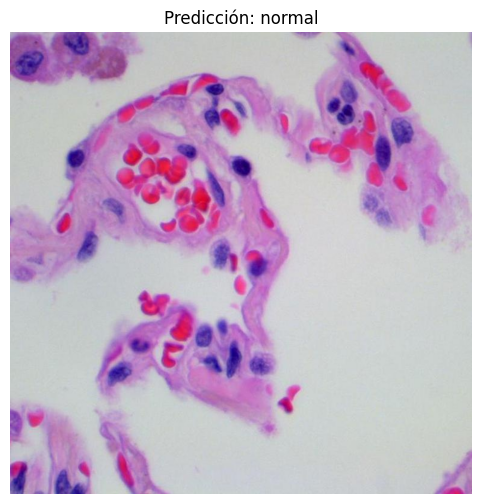

La imagen es clasificada como: normal


In [39]:
# Asegúrate de que tu modelo esté cargado y en el dispositivo correcto
# model = ...  # Tu modelo Inception_v3 cargado y entrenado
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tus nombres de clases
class_names = ['adenocarcinoma', 'normal', 'squamous cell carcinoma']  # Ajusta según tus clases reales

# Ruta a la imagen que quieres clasificar
#image_path = "./working/test/adenocarcinoma/0005.jpg"
image_path = "./working/test/benign/0282.jpg"
#image_path = "./working/test/squamous_cell_carcinoma/4999.jpg"
#image_path = "./0647.jpg"



# Realizar la predicción y visualizar
predicted_label = predict_and_visualize(model, image_path, class_names, device)
print(f"La imagen es clasificada como: {predicted_label}")